In [41]:
import math
import random
import datetime
from collections import defaultdict
from enum import Enum
import numpy as np 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
import gymnasium as gym
from gym import Env
from sklearn.model_selection import train_test_split
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from gym.utils.env_checker import check_env
from typing import (
    Type,
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
import stable_baselines3
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from torch.utils.tensorboard import SummaryWriter


- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

## config

In [3]:
config = {
    'SEED' : 41,
    'DEVICE' : 'cuda',
    'EPOCHS' : 2,
    'TIMESTEPS' : 1000,
    'N_X' : 100,
    'N_TASKS' : 5,
    'IN_FEATURES' : 1,
    'OUT_FEATURES' : 1,
    'POOL_N_LAYERS' : 30,
    'N_NODES_PER_LAYER' : 32,
    'POOL_LAYER_TYPE' : torch.nn.Linear,
    'ACTION_SPACE_SHAPE' : (3,),
    'EPSILON' : 0.1,
    'BATCH_SIZE' : 1,
    'LEARNING_RATE' : 0.01,
    'ACTION_CACHE_SIZE' : 5,
    'NUM_WORKERS' : 0,
    'LOSS_FN' : torch.nn.MSELoss(),
    'SB3_MODEL' : RecurrentPPO,
    'SB3_POLICY' : 'MlpLstmPolicy',
    'LOG_DIR' : 'runs',
    }
config

{'SEED': 41,
 'DEVICE': 'cuda',
 'EPOCHS': 2,
 'TIMESTEPS': 1000,
 'N_X': 100,
 'N_TASKS': 5,
 'IN_FEATURES': 1,
 'OUT_FEATURES': 1,
 'POOL_N_LAYERS': 30,
 'N_NODES_PER_LAYER': 32,
 'POOL_LAYER_TYPE': torch.nn.modules.linear.Linear,
 'ACTION_SPACE_SHAPE': (3,),
 'EPSILON': 0.1,
 'BATCH_SIZE': 1,
 'LEARNING_RATE': 0.01,
 'ACTION_CACHE_SIZE': 5,
 'NUM_WORKERS': 0,
 'LOSS_FN': MSELoss(),
 'SB3_MODEL': sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO,
 'SB3_POLICY': 'MlpLstmPolicy',
 'LOG_DIR': 'runs'}

In [4]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Decision Process"

- layer pool
- inner network -- composed of layers from layer pool
- outer network (meta learner) -- responsible for parameters and hyperparameters of inner network

In [5]:
# create tasks
# (20, 100) shape
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['N_X'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['N_TASKS'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['N_TASKS'])).float()
tasks_data = torch.tensor([ 
        X
        for _ in range(config['N_TASKS'])
        ]).float()
tasks_targets = torch.tensor([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ]).float()
tasks_info = [
        [{'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
         for _ in X]
        for i, (a, p) in enumerate(zip(amps, phases))
]

C:\Users\stach\AppData\Local\Temp\ipykernel_11436\1044802825.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:276.)
  tasks_data = torch.tensor([


In [6]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(1, 32),  
            torch.nn.Linear(32, 32), 
            torch.nn.Linear(32, 32),  
            torch.nn.Linear(32, 1)  
        ])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x



{'SEED': 41, 'DEVICE': 'cuda', 'EPOCHS': 2, 'TIMESTEPS': 1000, 'N_X': 100, 'N_TASKS': 5, 'IN_FEATURES': 1, 'OUT_FEATURES': 1, 'POOL_N_LAYERS': 30, 'N_NODES_PER_LAYER': 32, 'POOL_LAYER_TYPE': <class 'torch.nn.modules.linear.Linear'>, 'ACTION_SPACE_SHAPE': (3,), 'EPSILON': 0.1, 'BATCH_SIZE': 1, 'LEARNING_RATE': 0.01, 'ACTION_CACHE_SIZE': 5, 'NUM_WORKERS': 0, 'LOSS_FN': MSELoss(), 'SB3_MODEL': <class 'sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO'>, 'SB3_POLICY': 'MlpLstmPolicy', 'LOG_DIR': 'runs'}

5
2


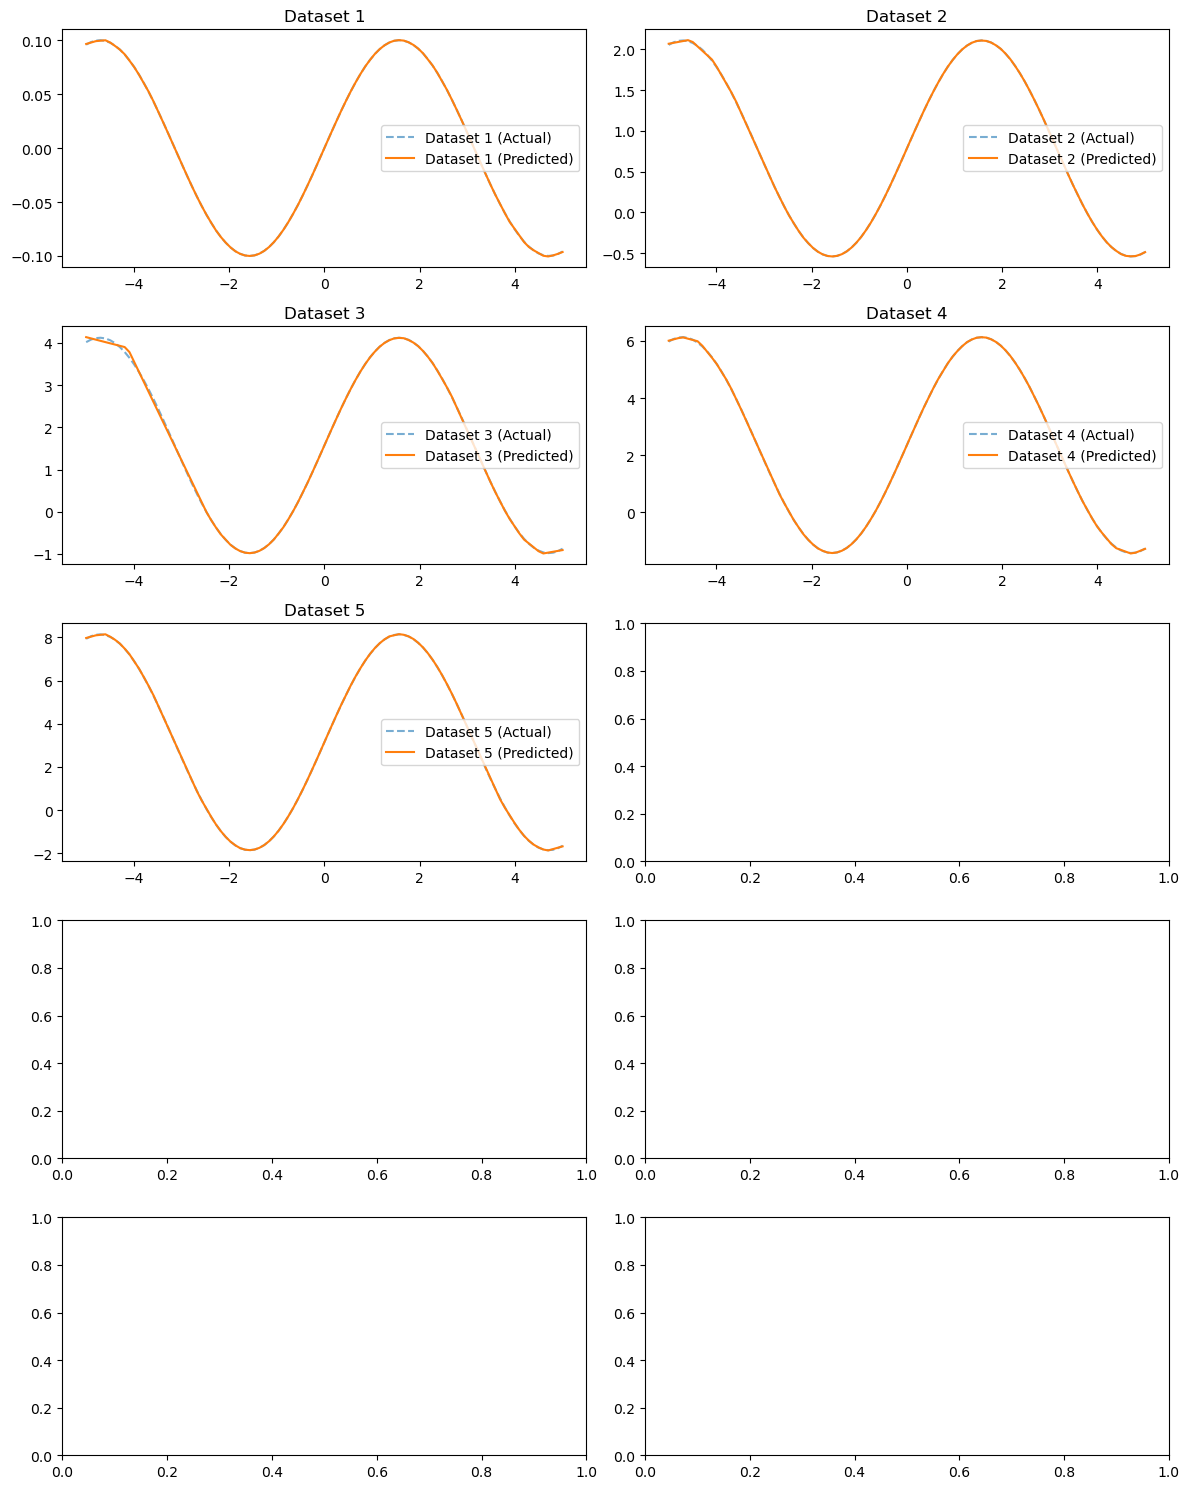

In [7]:
layers = []
data = []
for x, y in zip(tasks_data, tasks_targets):
    data.append([x,y])
print(config)
print()
print(len(data))
print(len(data[0]))
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
for i, (x, y) in enumerate(data):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # train before graphing
    num_epochs = 20000
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
    
    # get predicitons to graph
    model.eval()
    with torch.no_grad():
        outputs = model(x.view(-1, 1))
        test_loss = criterion(outputs, y.view(-1, 1))

    # graph truth vs. predictions
    row = i // 2
    col = i % 2
    axs[row, col].plot(x, y, label=f'Dataset {i + 1} (Actual)', linestyle='--', alpha=0.6)
    axs[row, col].plot(x, outputs.numpy(), label=f'Dataset {i + 1} (Predicted)')
    axs[row, col].set_title(f'Dataset {i + 1}')
    axs[row, col].legend()

    # save layers for layer pool
    layers.extend(model.layers)

plt.tight_layout()
plt.show()

In [8]:
print(f'Layers saved: n={len(layers)}, layers={layers}')

Layers saved: n=20, layers=[Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=

In [9]:
class Layer:
    def __init__(self, 
                params: Type[torch.nn.Linear]=config['POOL_LAYER_TYPE']):
        self.params = params
        self.used = False
        self.times_used = 0

class LayerPool:
    # pool of uniform Layer objects each with the same type and shape
    def __init__(self, 
                size: int=config['POOL_N_LAYERS'], 
                layer_type: Type[torch.nn.Linear]=config['POOL_LAYER_TYPE'],
                in_features: int=config['IN_FEATURES'],
                out_features: int=config['OUT_FEATURES'],
                num_nodes_per_layer: int=config['N_NODES_PER_LAYER'],
                layers: List[torch.nn.Linear]=None):
        self.size = size if layers is None else len(layers)
        self.layer_type = layer_type
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer

        # if no layers are passed, create and initialize layer pool from scratch
        if layers is None:
            self.layers = {
                i : Layer(params=self.layer_type(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer))
                for i in range(size)}
            for i in range(config['N_TASKS']):
                self.layers[size + i] = self.layer_type(in_features=in_features, out_features=num_nodes_per_layer)
            for i in range(config['N_TASKS']):
                self.layers[size + i] = self.layer_type(in_features=num_nodes_per_layer, out_features=out_features)
            [torch.nn.init.xavier_uniform_(layer.params.weight) for layer in self.layers.values()]
        else:
            self.layers = {
                i : Layer(params=layer) for i, layer in enumerate(layers)}
            config['POOL_N_LAYERS'] = len(self.layers)
        
    def __str__(self):
        return f"LayerPool(size={self.size}, layer_type={config['POOL_LAYER_TYPE']}, num_nodes_per_layer={config['N_NODES_PER_LAYER']}"

In [10]:
class InnerNetworkAction(Enum):
    NA = 0
    ADD = 1
    DELETE = 2
    ERROR = 3

In [11]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['N_X'], '[ERROR] Length should be the same as N_X.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info[index]
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data, self.targets}, info={self.info})'

In [ ]:
class InnerNetwork(gym.Env, Module):
    def __init__(self, 
                epoch: int,
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                in_features: int=config['IN_FEATURES'],
                out_features: int=config['OUT_FEATURES'],
                learning_rate: float=config['LEARNING_RATE'],
                batch_size: int=config['BATCH_SIZE'],
                epsilon: float=config['EPSILON'],
                action_cache_size: float=config['ACTION_CACHE_SIZE'],
                num_workers: int=config['NUM_WORKERS'],
                shuffle: bool=True,
                log_dir: str='runs',
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.layer_pool = layer_pool
        self.task = task
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)

        # need to add initial and final layers for reset() and step() in case action is NA (i.e., train)
        self.initial_layer = random.choice([layer 
                                          for layer in self.layer_pool.layers.values() 
                                          if getattr(layer.params, 'in_features', None) == in_features])
        self.final_layer = random.choice([layer 
                                          for layer in self.layer_pool.layers.values() 
                                          if getattr(layer.params, 'out_features', None) == out_features])

        self.layers = torch.nn.ModuleList([self.initial_layer.params, self.final_layer.params]) 
        self.pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.action_cache_size = action_cache_size
        self.actions_taken = [InnerNetworkAction.NA] * config['ACTION_CACHE_SIZE']
        self.writer = SummaryWriter(log_dir=log_dir)
        self.cum_reward = 0
        self.timestep = 0
        self.end_condition = False
        self.state = self.reset()
        state_shape = self.build_state().shape
        self.observation_space = gym.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=state_shape) # TODO is to normalize
        self.action_space = gym.spaces.discrete.Discrete(self.layer_pool.size * 3)


    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'

        self.timestep += 1
        self.train()
        self.next_batch()
        
        self.update_inner_network(action)
        self.run_inner_network()
        s_prime = self.build_state()
        reward = self.reward()
        self.tensorboard_log()

        return (
            s_prime,
            reward, 
            self.end_condition, 
            self.end_condition,
            {}
        )
    
    def handle_action(self, action: np.int64) -> None:
        if random.random() < self.epsilon: 
            action = random.randint(0, self.action_space.n - 1)

        # ADD 
        if (action < self.layer_pool.size):
            self.curr['action_type'] = InnerNetworkAction.ADD
            self.actions_taken.append(InnerNetworkAction.ADD)
        
        # DELETE 
        elif (action >= self.layer_pool.size and (action < self.layer_pool.size * 2)):
            adjusted_action_index = action - self.layer_pool.size
            # ERROR 
            if adjusted_action_index not in self.pool_indices: 
                self.curr['action_type'] = InnerNetworkAction.ERROR
                self.actions_taken.append(InnerNetworkAction.ERROR)
            elif self.layer_pool.layers[adjusted_action_index].params.in_features==self.in_features or self.layer_pool.layers[adjusted_action_index].params.out_features==self.out_features:
                self.curr['action_type'] = InnerNetworkAction.ERROR
                self.actions_taken.append(InnerNetworkAction.ERROR)
            else:
                self.curr['action_type'] = InnerNetworkAction.DELETE
                self.actions_taken.append(InnerNetworkAction.DELETE)

        # NA 
        else:
            self.curr['action_type'] = InnerNetworkAction.NA
            self.actions_taken.append(InnerNetworkAction.NA)
        
        return action 
    
    def update_inner_network(self, action: np.int64) -> None:
        # decide action_type (ADD, DELETE, NA, ERROR) with epsilon greedy
        action = self.handle_action(action)

        # execute the acton_type
        if (self.curr['action_type']==InnerNetworkAction.ADD): 
            next_layer = self.layer_pool.layers[action].params
            self.pool_indices.append(action)
            # handle new initial layer
            if next_layer.in_features==self.in_features:
                self.layers.pop(0) 
                self.layers.insert(0, next_layer)
            # handle new final layer
            elif next_layer.out_features==self.out_features:
                final_layer = self.layers.pop(-1)
                self.layers.append(final_layer)
            # handle hidden layers
            else:
                final_layer = self.layers.pop(-1) 
                self.layers.append(next_layer)  
                self.layers.append(final_layer) 
        elif (self.curr['action_type']==InnerNetworkAction.DELETE):
            adjusted_action_index = action - self.layer_pool.size
            self.pool_indices.remove(adjusted_action_index)
            layer_to_delete_weights = self.layer_pool.layers[adjusted_action_index].params
            network_index = self.get_layer_index(layer_to_delete_weights)
            assert layer_to_delete_weights == self.layers[network_index], '[ERROR] Wrong layer would be deleted from inner network params.'
            self.layers.pop(network_index)
        elif (self.curr['action_type']==InnerNetworkAction.NA or self.curr['action_type']==InnerNetworkAction.ERROR):
            return # no architecture updates
        else: 
            raise Exception(f"[ERROR] Unexpected action returned by inner network: {self.curr['action_type']}")

    def get_layer_index(self, target_weights: torch.nn.Linear) -> int:
        for i, layer in enumerate(self.layers):
            if isinstance(layer, torch.nn.Linear) and \
            torch.all(torch.eq(layer.weight, target_weights.weight)) and \
            torch.all(torch.eq(layer.bias, target_weights.bias)):
                return i
        return -1 
            
    def next_batch(self, throw_exception=False) -> None:
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)

        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x']
            self.curr['y'] = batch['y'] 
            self.curr['info'] = batch['info']
            assert self.curr['x'] != self.prev['x'], '[ERROR] Incorrect batch. Previous value equals new value.'
            assert self.curr['y'] != self.prev['y'], '[ERROR] Incorrect batch. Previous value equals new value.'
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x']
                self.curr['y'] = batch['y'] 
                self.curr['info'] = batch['info']
                assert self.curr['x'] != self.prev['x'], '[ERROR] Incorrect batch. Previous value equals new value.'
                assert self.curr['y'] != self.prev['y'], '[ERROR] Incorrect batch. Previous value equals new value.'
    
    def run_inner_network(self) -> None: 
        if self.training:
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward(self.curr['x'])
            loss = self.curr['loss']
            loss.backward()
            self.opt.step()
        else:
            self.forward(self.curr['x'])

    def forward(self, x) -> None:
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['prev_loss'] = self.curr['loss']
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
        assert self.curr['latent_space'].dtype == torch.float32
        assert self.curr['y_hat'].dtype == torch.float32

    def build_state(self) -> np.ndarray:
        one_hot_network_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i].params in self.layers else 0 
                                   for i in range(len(self.layer_pool.layers))]))
        num_add_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.ADD, self.actions_taken)))).unsqueeze(0)
        num_delete_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.DELETE, self.actions_taken)))).unsqueeze(0)
        num_layers = torch.tensor(len(self.layers)).unsqueeze(0)
        h = torch.tensor([action_enum.value for action_enum in self.actions_taken[-self.action_cache_size:]])
        task_info = torch.tensor([float(value) for value in self.curr['info'].values()])

        # sequence_network_layers = torch.tensor(np.array([index + 1 for index in self.pool_indices] + [0] * (self.layer_pool.size - len(self.pool_indices))))

        return torch.concat((
            # about the task
            task_info,
            self.curr['x'],
            # about the inner network's choices
            self.curr['latent_space'],
            self.curr['y'],
            self.curr['y_hat'],
            # about the meta network's choices
            one_hot_network_layers,
            num_add_actions,
            num_delete_actions,
            num_layers,
            h
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        prev_loss = self.curr['prev_loss'] or None
        curr_loss = self.curr['loss']
        loss_delta = prev_loss - curr_loss if prev_loss is not None else curr_loss
        if (self.curr['action_type'] == InnerNetworkAction.ADD):
            reward = loss_delta / math.sqrt(len(self.layers))
        elif (self.curr['action_type'] == InnerNetworkAction.DELETE or self.curr['action_type'] == InnerNetworkAction.NA):
            reward = loss_delta
        elif (self.curr['action_type'] == InnerNetworkAction.ERROR):
            reward = -1000
        else:
            raise Exception('[ERROR] Invalid action type.')
        self.curr['reward'] = reward
        self.cum_reward += reward
        return reward

    def tensorboard_log(self):
        task_num = str(self.curr['info']['i'].item())
        self.writer.add_scalar(f'loss_epoch{self.epoch}_task{task_num}', self.curr['loss'], global_step=self.timestep) 
        self.writer.add_scalar(f'num_layers_epoch{self.epoch}_task{task_num}', len(self.layers), global_step=self.timestep) 
        self.writer.add_scalar(f'reward_epoch{self.epoch}_task{task_num}', self.curr['reward'], global_step=self.timestep)
        if (len(self.pool_indices)!=0):
            self.writer.add_histogram(f'pool_indices_epoch{self.epoch}_task{task_num}', torch.tensor(self.pool_indices).long(), global_step=self.timestep) 
        self.writer.add_histogram(f'action_types_epoch{self.epoch}_task{task_num}', torch.tensor([e.value for e in self.actions_taken]).long(), global_step=self.timestep) 

    def reset(self, seed=None) -> np.ndarray:
        self.eval()
        self.next_batch()
        self.run_inner_network()
        return self.build_state(), None

In [33]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['SB3_MODEL'],
        policy=config['SB3_POLICY'],
        epochs: int=config['EPOCHS'],
        timesteps: int=config['TIMESTEPS'],
        device: str=config['DEVICE'],
        overwrite: bool=True,  # TODO is to revisit this param
        intra_update: bool=True, # TODO is to revisit this param
        log_dir: str=config['LOG_DIR'],
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.model = model
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite 
        self.intra_update = intra_update
        self.log_dir = log_dir
    
    def __str__(self):
        return f'REML(model={self.model}, policy={self.policy})'

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        # therefore the number of steps is (timesteps)*(n)*(m)
        first_run = True
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch {epoch + 1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task num={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.env = InnerNetwork(epoch, task, self.layer_pool, log_dir=self.log_dir)
                if first_run: 
                    model = self.model(self.policy, 
                                       self.env,
                                       n_steps=config['N_X'],
                                       tensorboard_log=self.log_dir,)
                    first_run = False
                    
                else: 
                    model.set_env(self.env)

                # train meta learner on task
                model.learn(total_timesteps=self.timesteps, 
                            tb_log_name=f'epoch_{epoch}_task_{i}',
                            reset_num_timesteps=True)

                # epoch log
                self.env.writer.add_scalar(f'loss/epoch{epoch}_task{i}', self.env.curr['loss'], global_step=epoch) 
                self.env.writer.add_scalar(f'cumulative_reward/epoch{epoch}_task{i}', self.env.cum_reward, global_step=epoch) 
                yhats = self.evaluate_inner_network()
                print(f'[INFO] Task data: {self.env.task.data}')
                print(f'[INFO] Task data length: {len(self.env.task.data)}') # seeking to confirm its 100 values
                print(f'[INFO] yhats data length: {len(yhats)}') # seeking to confirm its 100 values
                for x, yhat in zip(self.env.task.data, yhats):
                    self.env.writer.add_scalar(f'sin_curve/epoch{epoch}_task{i}', yhat, global_step=x)
                self.env.writer.close()

                # update pool
                # larger problem is that we have multiple copes of each layer, so which copy do we add
                print(f'[INFO] Number of layers in self.env.layers: {len(self.env.layers)}')
                print(f'[INFO] Number of indices in self.env.pool_indices: {len(self.env.pool_indices)}')
                # for i in range(len(self.env.pool_indices)):
                #     pool_index = self.env.pool_indices[i]
                #     updated_layer_copy = self.env.layers[i+1]
                #     self.layer_pool.layers[pool_index].params = updated_layer_copy
                #     self.layer_pool.layers[pool_index].used = True
                #     self.layer_pool.layers[pool_index].times_used += 1
    
    def evaluate_inner_network(self):
        try:
            self.env.eval()
            y_hats = []
            # new dataloader to go through full dataset
            self.env.data_loader = DataLoader(self.env.task, batch_size=self.env.batch_size, shuffle=self.env.shuffle, num_workers=self.env.num_workers)
            self.env.data_iter = iter(self.env.data_loader)
            while True:
                self.env.next_batch(throw_exception=True)
                # self.env.forward(self.env.curr['x'])

                x = self.env.curr['x']
                for i in range(len(self.env.layers) - 1): 
                    x = torch.nn.functional.relu(self.env.layers[i](x))
                    print(f'interim x: {x}') # expecting it be 0 value
                self.env.curr['latent_space'] = x
                print(f'bias: {self.env.layers[-1].bias}')
                self.env.curr['y_hat'] = self.env.layers[-1](x) 
                self.env.curr['prev_loss'] = self.env.curr['loss']
                self.env.curr['loss'] = self.env.loss_fn(self.env.curr['y'], self.env.curr['y_hat'])

                print(f"[INFO] x={self.env.curr['x']}, y_hat={self.env.curr['y_hat']}, y={self.env.curr['y']}")
                y_hats.append(x)
        except StopIteration:
            pass
        return y_hats

### testing
However, 2 epoch is still going through all 20 tasks, generating 20 different networks, using the same 1 meta policy. Also, on each task we loop through the data 1000 times (timesteps / len(X) == 10000 / 100).
<br>
The benefit of more epochs is we get the meta policy to gnerate 20 different networks again for the 20 tasks, having hopefully learned something from the first run.

### sinusoidal curves regression as in 2018 MAML paper

In [34]:
# create tasks
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['N_X'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['N_TASKS'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['N_TASKS'])).float()

# (20, 100)
tasks_data = torch.tensor([ 
        X
        for _ in range(config['N_TASKS'])
        ]).float()
tasks_targets = torch.tensor([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ]).float()
tasks_info = [
        [{'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
         for _ in X]
        for i, (a, p) in enumerate(zip(amps, phases))
]

In [35]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([5, 100])
torch.float32
torch.Size([5, 100])
torch.float32
5
100


In [36]:
# run
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['N_TASKS'])]
pool = LayerPool(layers=layers)
log_dir = f'./runs/ppo_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
model = REML(layer_pool=pool, tasks=tasks, log_dir=log_dir)

In [37]:
model.__str__()

"REML(model=<class 'sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO'>, policy=MlpLstmPolicy)"

In [38]:
model.train()

[INFO] Epoch 1/2
[INFO] Task num=1/5
interim x: tensor([0.0000, 0.5775, 0.5645, 0.0000, 0.0000, 2.0270, 1.0406, 0.7293, 0.0000,
        0.0000, 0.2401, 0.0000, 0.8533, 0.3580, 0.2450, 0.2613, 0.7418, 0.2433,
        1.4640, 0.0000, 0.0000, 0.6181, 0.0000, 0.0000, 0.0000, 0.0000, 1.3776,
        0.0000, 0.0000, 0.4789, 0.0000, 0.9797], grad_fn=<ReluBackward0>)
interim x: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0784, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)
interim x: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2307,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4199, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<Relu

AssertionError: Tensor should contain one element (0 dimensions). Was given size: 32 and 1 dimensions.

In [72]:
# double check that the network parameters are changing, add an assert
# move to py file and schedule batch job with A100
    # DELETE vs. no DELETE action
    # bounded vs. unbounded networks
    # try using the vectorized environments
# normalize the output space or whatever
# use the networks that are built to predict yhats and plot the graph (visual representation of learning)

In [313]:
# (2, 20)
yhats = model.yhats_by_epoch_by_task
indices = model.layerindices_by_epoch_by_task
actions = model.actions_taken_by_epoch_by_task

AttributeError: 'REML' object has no attribute 'yhats_by_epoch_by_task'

C:\Users\stach\AppData\Local\Temp\ipykernel_12716\4051386411.py:17: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y.unsqueeze(0), yhat.unsqueeze(0))


NameError: name 'loss_by_epoch_by_task' is not defined

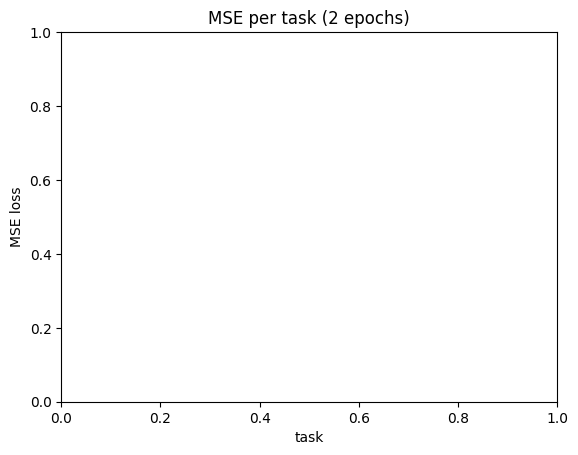

In [20]:
# # yhats
# # x is task
# # y is loss per task averaged over epochs
# plt.xlabel('task')
# plt.ylabel('MSE loss')
# plt.title('MSE per task (2 epochs)')

# # calculate loss values as average for the task for the epoch
# loss_by_task = []
# for (epoch, epoch_dict) in yhats.items(): # 2 epochs
#     epoch_vals = []
#     for task, (key, yhat_values) in zip(tasks, epoch_dict.items()): # 20 tasks
#         # key is task id, which is string of task_info
#         # value is list of yhats or list of tensors
#         losses_by_task = [] 
#         for y, yhat in zip(task.targets, yhat_values):
#             loss = F.mse_loss(y.unsqueeze(0), yhat.unsqueeze(0))
#             loss = loss.detach().numpy()
#             losses_by_task.append(loss)
#         loss_by_task.append(sum(losses_by_task) / len(losses_by_task))
    
# loss_by_epoch_by_task = np.array(loss_by_epoch_by_task)
# print(f'loss_by_epoch_by_task shape={loss_by_epoch_by_task.shape}')

# #         losses = []
# #         for y, y_hat in zip(data[1], y_hats): # 100 values
# #             y_hat = y_hat.unsqueeze(0)
# #             y = torch.tensor(y).unsqueeze(0) # can't iterate over 0d tensors
# #             loss = F.mse_loss(y, y_hat)
# #             losses.append(loss)
# #     loss_by_task.append( (sum(losses)/len(losses)).detach().numpy() ) # can't plot tensor values
# # print(loss_by_task)

# plt.scatter(
#     range(1, config['N_TASKS'] + 1), 
#     loss_by_task
#     )

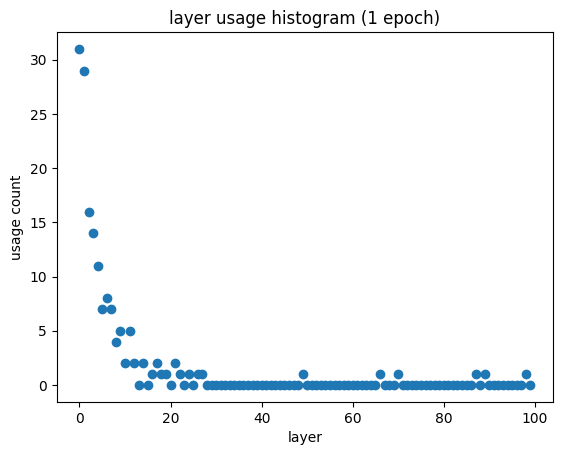

In [568]:
# plot layer use for all tasks
plt.xlabel('layer')
plt.ylabel('usage count')
plt.title('layer usage histogram (1 epoch)')
plt.scatter(
    range(N_X), 
    [layer.times_used for layer in pool.layers.values()]
    );

### Loss w/ transfer vs. w/o transfer

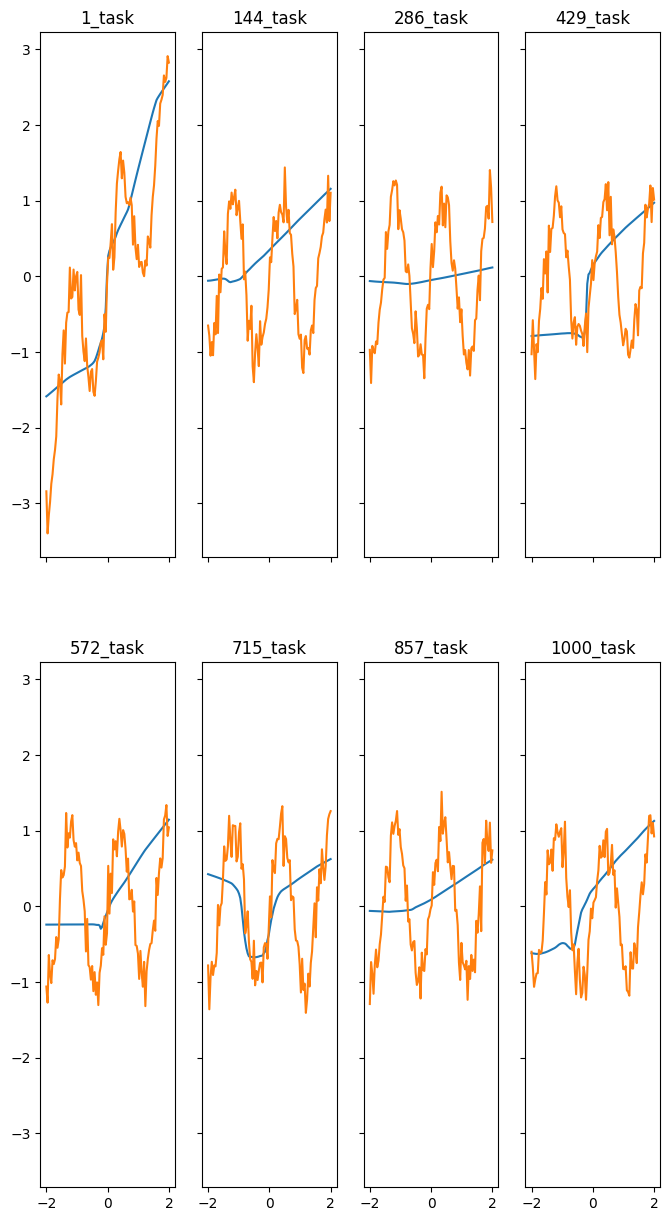

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1